# MLP with PyTorch

## Prep the data

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# load data
data = pd.read_csv('Datafiniti_Hotel_Reviews.csv')

# drop unnecessary columns
data = data.drop(columns=['address', 'country', 'name', 'postalCode', 'dateAdded',
             'id', 'reviews.text', 'reviews.title', 'reviews.userCity', 'reviews.username',
             'reviews.userProvince'])

# filter city and category to top 10 and other for rest
top_cit = data['city'].value_counts().nlargest(10).index
data['city'] = data['city'].apply(lambda x: x if x in top_cit else 'Other')

top_cat = data['categories'].value_counts().nlargest(10).index
data['categories'] = data['categories'].apply(lambda x: x if x in top_cat else 'Other')

# get date features
data['reviews.date'] = pd.to_datetime(data['reviews.date'], errors='coerce')
data['review.year'] = data['reviews.date'].dt.year
data['review.month'] = data['reviews.date'].dt.month
data = data.drop(columns=['reviews.date'])

# One-hot encoding the categorical features
data = pd.get_dummies(data, drop_first=True, dtype=int)

# drop any rows with NaNs
data = data.dropna()

X = data.drop(columns=['reviews.rating']).values

# make reviews rating into 1 if the star rating is 4 or 5 
# make it 0 if it is below 4, good and bad ratings
y = (data['reviews.rating'] >= 4).astype(int).values

# min-max scaling
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)

# add intercept/bias column to X
Phi = np.hstack((np.ones((X_scale.shape[0], 1)), X_scale))

# Separating data into training and test sets
[X_train, X_test, y_train, y_test] = train_test_split(Phi, y, test_size = .3)

/Users/aidenshymanski/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/aidenshymanski/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## Train Model and Record Loss

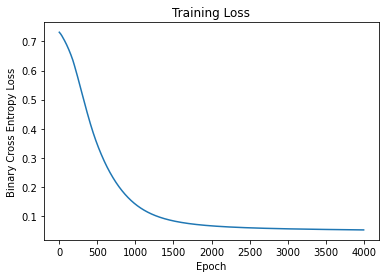

In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(32, 16)
        self.l3 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x))
        x = self.sigmoid(self.l3(x))
        return x

# convert to PyTorch tensors
X_train_tens = torch.tensor(X_train, dtype=torch.float32)
y_train_tens = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_tens  = torch.tensor(X_test, dtype=torch.float32)

model = MLP(X_train_tens.shape[1])

# Binary Cross Entropy seems to bbe the closest to the log loss objective function we used
loss = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 4000

# keep track of gradient descent errors
# to monitor convergence
errors = []

# gradient descent
for epoch in range(epochs):
    model.train()
    y_pred = model(X_train_tens)

    optimizer.zero_grad()
    losses = loss(y_pred, y_train_tens)
    errors.append(losses.item())
    losses.backward()
    optimizer.step()

plt.plot(range(epochs), errors)
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy Loss")
plt.title("Training Loss")
plt.show()


## Evaluate Model

In [6]:
print("Layer 1 Weights:", model.l1.weight.data)

print("\nLayer 2 Weights:", model.l2.weight.data)

print("\nLayer 3 Weights:", model.l3.weight.data)

Layer 1 Weights: tensor([[ 0.0513,  0.0561,  0.0568,  ...,  0.0630, -0.0228,  0.1129],
        [ 0.0888,  0.0918,  0.0836,  ...,  0.0314, -0.0272, -0.1022],
        [ 0.0627,  0.0681,  0.0574,  ..., -0.0090, -0.0543, -0.0938],
        ...,
        [ 0.1334,  0.1311,  0.1390,  ...,  0.1348,  0.1207,  0.1139],
        [ 0.0343,  0.0226,  0.0229,  ...,  0.0254,  0.0514,  0.1186],
        [ 0.0662,  0.0611,  0.0555,  ..., -0.0211, -0.0602, -0.1167]])

Layer 2 Weights: tensor([[-1.8321e-01,  2.1988e-01,  2.6006e-01,  7.6354e-02,  1.3115e-01,
          2.6696e-01,  1.7569e-01, -1.7929e-01,  3.0072e-01, -3.3206e-01,
         -2.7934e-01,  1.5933e-01,  2.8178e-01,  2.5730e-02,  2.7905e-01,
          1.8399e-01,  3.2649e-01, -4.1188e-01, -4.3117e-01, -4.1011e-01,
         -2.1094e-01,  8.0471e-02,  6.5444e-02,  2.3175e-01, -3.6926e-01,
         -3.1028e-01,  1.6944e-01,  1.5672e-01, -3.0258e-01,  2.5240e-01,
         -2.9053e-01,  1.6170e-01],
        [ 1.8492e-01, -1.2266e-01, -7.5832e-02, -2.

In [3]:
# predict using the test data
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tens)
    y_test_pred_class = (y_test_pred > 0.5).float()

    accuracy = accuracy_score(y_test, y_test_pred_class.numpy())
    print(f'Accuracy: {accuracy:.3f}')

    precision = precision_score(y_test, y_test_pred_class.numpy())
    print(f'Precision: {precision:.3f}')

    recall = recall_score(y_test, y_test_pred_class.numpy())
    print(f'Recall: {recall:.3f}')

    f1 = f1_score(y_test, y_test_pred_class.numpy())
    print(f'F1 Score: {f1:.3f}')



Accuracy: 0.707
Precision: 0.786
Recall: 0.829
F1 Score: 0.807


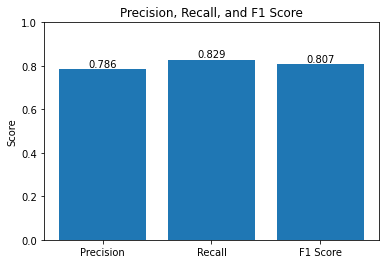

In [4]:
scores = [precision, recall, f1]
labels = ['Precision', 'Recall', 'F1 Score']
bars = plt.bar(labels, scores)
plt.ylim([0, 1])
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score')

for i in range(len(labels)):
    plt.text(i, scores[i], str(round(scores[i], 3)), ha='center', va='bottom')

plt.show()